In [1]:
from solver_NerveNet_U import Solver
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torchvision import transforms, datasets
from classifiers.NerveNet_U import NerveNET
import transform_utils_NerveNet as tu
from dice_loss import DiceLoss

from data_utils_NerveNet import SegmentationData

%load_ext autoreload
%autoreload 2

In [2]:
img_files = '../data/image_files.txt'
num_lines = sum(1 for line in open(img_files, 'r'))
nums = {'num_train' : int(0.6*num_lines)+2,
        'num_val'   : int(0.2*num_lines),
        'num_test' : int(0.2*num_lines)}

print(nums, num_lines)
print(np.sum(list(nums.values())) == num_lines)

{'num_train': 3383, 'num_val': 1127, 'num_test': 1127} 5635
False


In [3]:
input_dim = (1, 128, 128)
W, H = input_dim[1::]
W4, H4 = int(W / 2**3), int(H / 2**3)
W5, H5 = int(W / 2**4), int(H / 2**4)
resize_to_layer4 = (W4, H4)
resize_to_layer5 = (W5, H5)

transform1 = tu.Resize(input_dim[1::])
transform2 = tu.Resize(resize_to_layer4)
transform3 = tu.Resize(resize_to_layer5)
random_transforms = tu.Compose([
                        tu.RandomHorizontalFlip(),
                        tu.RandomVerticalFlip(),
                        tu.ToTensor()])

data_transform = [transform1, transform2, transform3, random_transforms]


train_data = SegmentationData(img_files, transform = data_transform, mode = 'train', **nums)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=12,
                                           shuffle=True,
                                           num_workers=4)

val_data = SegmentationData(img_files,  transform = data_transform, mode = 'val', **nums)
val_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=12,
                                           shuffle=True,
                                           num_workers=4)

In [4]:
model = NerveNET(input_dim, num_classes = 2, weight_scale = 0.01, dropout = 0.15)
#model = torch.load("models/NerveNet_v1.model")

In [22]:
#for param in list(model.parameters()):
#    param.requires_grad = False
    
#for param in list(model.parameters())[-2::]:
#    param.requires_grad = True

solver = Solver(optim_args={"lr": 0.001, #0.0025, #1.e-3, #1.e-2
                            "betas": (0.9, 0.999),
                            "eps": 1e-8,
                            "weight_decay": 0.},
                loss_func = DiceLoss(), loss_weights = [1.0, 0.0, 0.0, 0.0])

#print(model)
outputs = solver.train(model, train_loader, val_loader, log_nth=100, num_epochs=5)

START TRAIN.
[Iteration 100/1410] TRAIN loss: 0.666
[Iteration 200/1410] TRAIN loss: 0.668
[Epoch 1/5] TRAIN acc/loss: 0.395/0.668
[Iteration 382/1410] TRAIN loss: 0.659
[Iteration 482/1410] TRAIN loss: 0.670
[Epoch 2/5] TRAIN acc/loss: 0.342/0.670
[Iteration 664/1410] TRAIN loss: 0.659
[Iteration 764/1410] TRAIN loss: 0.656
[Epoch 3/5] TRAIN acc/loss: 0.401/0.656
[Iteration 946/1410] TRAIN loss: 0.661
[Iteration 1046/1410] TRAIN loss: 0.672
[Epoch 4/5] TRAIN acc/loss: 0.308/0.672
[Iteration 1228/1410] TRAIN loss: 0.663
[Iteration 1328/1410] TRAIN loss: 0.648
[Epoch 5/5] TRAIN acc/loss: 0.299/0.648
FINISH.


In [23]:
model.save("../models/NerveNet_U_v1_weights0_2.model")

Saving model... ../models/NerveNet_U_v1_weights0_2.model


In [24]:
test_data_transform = transforms.Resize(input_dim[1::])
img_files = '../data/image_files.txt'


test_data = SegmentationData(img_files,  transform = data_transform, mode = 'test', **nums)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=12,
                                          shuffle=False,
                                          num_workers=1)

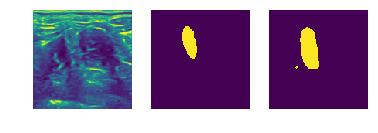

In [25]:
model.eval()

img, targets = test_data[9]

target = targets['in']
inputs = img.unsqueeze(0)
inputs = Variable(inputs)

model=model.cpu()

outputs = model.forward(inputs)
pred = outputs[0].squeeze().data.cpu().numpy()

img=np.squeeze(img)
target = target.squeeze().numpy()

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(target)
ax[1].axis('off')
ax[2].imshow(np.where(pred>0.1, 1, 0))
ax[2].axis('off')
plt.show()

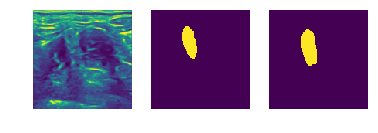

In [26]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(target)
ax[1].axis('off')
ax[2].imshow(np.where(pred < 0.5, 0, 1))
ax[2].axis('off')
plt.show()

In [27]:
np.where(pred < 0.5, 0, 1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

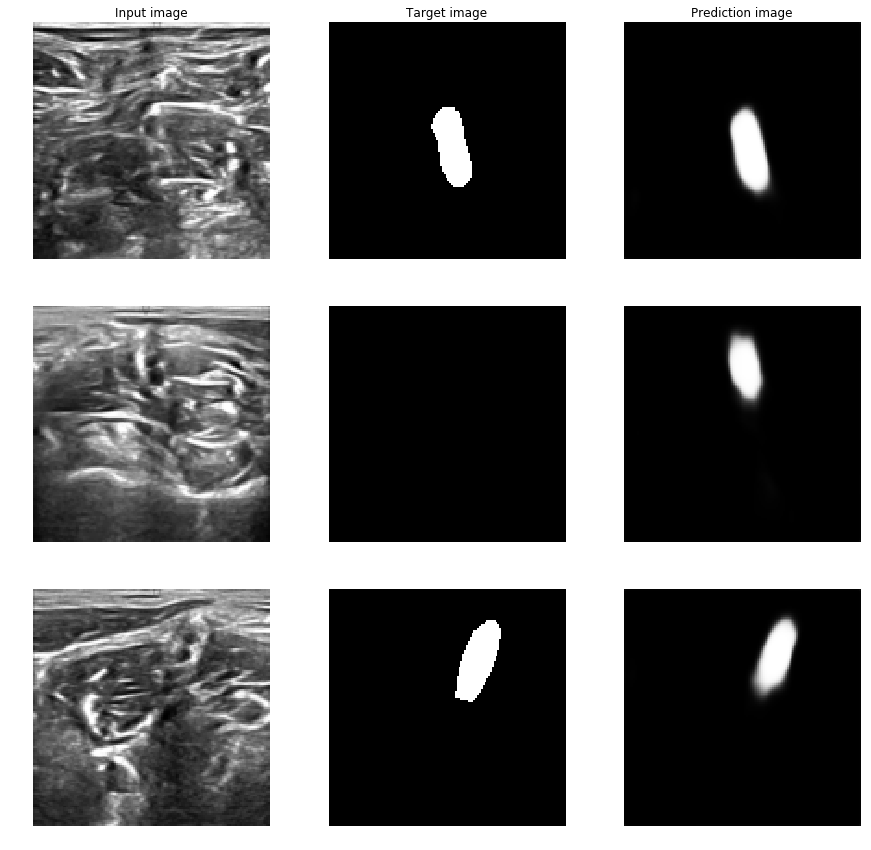

In [28]:
num_example_imgs = 4
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, targets) in enumerate(test_data[1:4]):
    
    target = targets['in']
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)

    outputs = model.forward(inputs)
    pred = outputs[0].squeeze().data.cpu().numpy()

    img=np.squeeze(img)
    target = target.squeeze().numpy()
        
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(target, cmap='gray')
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(pred, cmap='gray')
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

In [29]:
def dice_coefficient(ground_truth, predicted):
    gt = ground_truth
    p = predicted
    if np.sum(p) + np.sum(gt) == 0:
        return 1
    else:
        dice = np.sum(p[gt==1])*2.0 / (np.sum(p) + np.sum(gt))
        return dice

test_scores = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = Variable(inputs), Variable(targets['in'])
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    
    outputs = model.forward(inputs)
    preds = outputs[0]
    test_scores.append(dice_coefficient(np.squeeze(targets.data.numpy()), np.squeeze(np.where(preds.data.numpy() > 0.1, 1, 0))))#np.mean((preds == targets)[targets_mask].data.cpu().numpy()))
    
model.train()
np.mean(test_scores)

0.29290173800182051